# Fitting a simple slab model

In order to show one of the simplest analyses that `easyreflectometry` can perform, we will use the [great example from the *refnx* documentation](https://refnx.readthedocs.io/en/latest/getting_started.rst#Fitting-a-neutron-reflectometry-dataset).
This involves the analysis of a single neutron reflectometry dataset from a hydrated polymer film system. 
Before we start on any analysis, we will import the necessary packages and functions.

First configure matplotlib to place figures in notebook and import needed modules.
Note that the plot function needs installation of `plopp` seperately or installation of `easyreflectometry[dev]`

In [1]:
%matplotlib inline

import pooch
import refnx

import easyreflectometry

from easyreflectometry.data import load
from easyreflectometry.sample import Layer
from easyreflectometry.sample import Sample
from easyreflectometry.sample import Material
from easyreflectometry.sample import Multilayer
from easyreflectometry.model import Model
from easyreflectometry.model import PercentageFwhm
from easyreflectometry.calculators import CalculatorFactory
from easyreflectometry.fitting import MultiFitter
from easyreflectometry.plot import plot

One of benefits of using a Jupyter Notebook for our analysis is improved reproducibility, to ensure this, below we share the version of the software packages being used.

In [2]:
print(f'easyreflectometry: {easyreflectometry.__version__}')
print(f'refnx: {refnx.__version__}')

easyreflectometry: 1.3.1
refnx: 0.1.52


## Reading in experimental data

`easyreflectometry` has support for the `.ort` file format, a [standard file format for reduced reflectivity data developed by the Open Reflectometry Standards Organisation](https://www.reflectometry.org/working_groups/file_formats/).
To load in a dataset, we use the `load` function.
We use `pooch` to fetch the file from the repository.

In [3]:
file_path = pooch.retrieve(
    # URL to one of Pooch's test files
    url="https://raw.githubusercontent.com/EasyScience/EasyReflectometryLib/master/docs/src/tutorials/fitting/example.ort",
    known_hash="82d0c95c069092279a799a8131ad3710335f601d9f1080754b387f42e407dfab",
)
data = load(file_path)

The function about will load the file into a [*scipp* Dataset](https://scipp.github.io/user-guide/data-structures.html#Dataset) object. 
This offers some nice visualisations of the data, including the HTML view. 

In [4]:
data

DataGroup(sizes={}, keys=[
    data: {'R_0': <scipp.Variable> (Qz_0: 408)    float64  [dimensionless]  [0.709581, 0.862281, ..., 3.85579e-07, 3.83415e-07]  [0.0072365, 0.012627, ..., 3.10264e-14, 3.55149e-14]},
    coords: {'Qz_0': <scipp.Variable> (Qz_0: 408)    float64           [1/Å]  [0.00806022, 0.00813662, ..., 0.460946, 0.465555]  [1.98083e-08, 2.01923e-08, ..., 8.97175e-05, 9.20225e-05]},
    attrs: {'R_0': {'orso_header': <scipp.Variable> ()   PyObject        <no unit>  {'data_source': {'owner': {'name': 'Andrew Nelson', 'affiliation': 'ANSTO', 'contact': 'Andrew.Nelson@ansto.gov.au'}, 'experiment': {'title': 'Example data file from refnx docs', 'instrument': 'platypus', 'start_date': datetime.datetime(2021, 5, 12, 0, 0), 'probe': 'neutron', 'facility': 'ANSTO'}, 'sample': {'name': 'Polymer Film', 'category': 'solid / liquid', 'composition': 'Si / SiO2 / Film / D2O'}, 'measurement': {'instrument_settings': {'incident_angle': {'magnitude': 3.0, 'unit': 'deg'}, 'wavelength': {'magnitude': 12.0, 'unit': 'angstrom'}, 'polarization': 'unpolarized'}, 'data_files': ['Unknown.nxs'], 'scheme': 'angle-dispersive'}}, 'reduction': {'software': {'name': 'ess'}, 'timestamp': datetime.datetime(2022, 1, 27, 15, 33, 59, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'corrections': ['footprint', 'incident intensity', 'detector efficiency']}, 'columns': [{'name': 'Qz', 'unit': '1/angstrom', 'dimension': 'WW transfer'}, {'name': 'R', 'dimension': 'reflectivity'}, {'name': 'sR', 'dimension': 'error-reflectivity'}, {'name': 'sQz', 'unit': '1/angstrom', 'dimension': 'resolution-WW transfer'}]}}},
])

`easyreflectometry` also includes a custom plotting function for the data. 

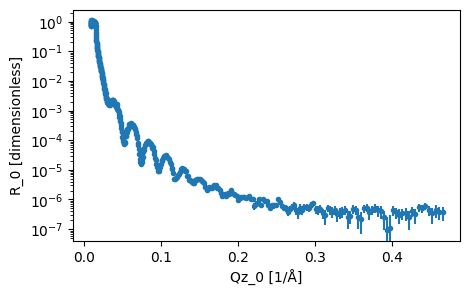

In [5]:
plot(data)

## Building our model

Now that we have read in the experimental data that we want to analyse, it is necessary that we construct some model that describes what we **think** the system looks like. 
The construction of this models is discussed in detail in the [model-dependent analysis](https://www.reflectometry.org/isis_school/2_model_dependent_analysis/what_is_model_dependent_analysis.html) and [reflectometry slab models](https://www.reflectometry.org/isis_school/3_reflectometry_slab_models/the_slab_model.html) sections of the ISIS Virtual Reflectometry Training Course on [neutron reflectometry fitting](https://www.reflectometry.org/isis_school/intro.html). 

The system that we are investigating consists of four layers (with the top and bottom as semi-finite super- and sub-phases). 
The super-phase (where the neutrons are incident first) is a silicon (Si) wafer and as a process of the sample preparation there is anticipated to by a layer of silicon dioxide (SiO<sub>2</sub>) on this material.
Then a polymer film has been attached to the silicon dioxide by some chemical method and this polymer film is solvated in a heavy water (D<sub>2</sub>O) which also makes up the sub-phase of the system. 
This is shown pictorially below, as a slab model. 

<center>
    <img src='polymer_film.png' alt='A slab model description of the polymer film system.' width='300px'></img>
</center>
<center>
    A slab model description of the polymer film system (note that the layers are <b>not</b> to scale), showing the four layers of silicon, silicon dioxide, the polymer film and the heavy water subphase.
</center>

In order to constuct this model in `EasyReflecotmetry`, first we must construct objects for each of the materials that will compose the layers.
These objects should be of type `Material`, when constructed `from_pars` the arguments are the real and imaginary components of the scattering length density (in units of 10<sup>-6</sup>Å<sup>-2</sup>) and some name for the material. 

In [6]:
si = Material(sld=2.07, isld=0, name='Si')
sio2 = Material(sld=3.47, isld=0, name='SiO2')
film = Material(sld=2.0, isld=0, name='Film')
d2o = Material(sld=6.36, isld=0, name='D2O')

We can investigate the properties of one of these objects as follows.

In [7]:
film

Film:
  sld: 2.000e-6 1/Å^2
  isld: 0.000e-6 1/Å^2

Next we will produce layers from each of these materials, of type `Layer`. The `from_pars` constructor for these take the material, a thickness and a interfacial roughness (on the top of the layer). The thickness and roughness values are both in Å. 

In [8]:
si_layer = Layer(material=si, thickness=0, roughness=0, name='Si layer')
sio2_layer = Layer(material=sio2, thickness=30, roughness=3, name='SiO2 layer')
film_layer = Layer(material=film, thickness=250, roughness=3, name='Film Layer')
subphase = Layer(material=d2o, thickness=0, roughness=3, name='D2O Subphase')

Again, we can probe the properties of the layer as such.

In [9]:
film_layer

Film Layer:
  material:
    Film:
      sld: 2.000e-6 1/Å^2
      isld: 0.000e-6 1/Å^2
  thickness: 250.000 Å
  roughness: 3.000 Å

Given that the silicon and silicon dioxide layer both compose the solid subphase, it can be helpful to combine these as a `Multilayer` [assembly type](../basic/assemblies_library.rst#multilayer) in our code. 

In [10]:
superphase = Multilayer([si_layer, sio2_layer], name='Si/SiO2 Superphase')

These objects are then combined as a `Sample`, where the constructor takes a series of layers (or some more complex `easyreflectometry` [assemblies](../basic/assemblies_library.rst)) and, optionally, some name for the sample.

In [11]:
sample = Sample(superphase, Multilayer(film_layer), Multilayer(subphase), name='Film Structure')

This sample can be investigated from the string representation like the other objects. 

In [12]:
sample

Film Structure:
- Si/SiO2 Superphase:
    Si layer/SiO2 layer:
    - Si layer:
        material:
          Si:
            sld: 2.070e-6 1/Å^2
            isld: 0.000e-6 1/Å^2
        thickness: 0.000 Å
        roughness: 0.000 Å
    - SiO2 layer:
        material:
          SiO2:
            sld: 3.470e-6 1/Å^2
            isld: 0.000e-6 1/Å^2
        thickness: 30.000 Å
        roughness: 3.000 Å
- EasyMultilayer:
    Film Layer:
    - Film Layer:
        material:
          Film:
            sld: 2.000e-6 1/Å^2
            isld: 0.000e-6 1/Å^2
        thickness: 250.000 Å
        roughness: 3.000 Å
- EasyMultilayer:
    D2O Subphase:
    - D2O Subphase:
        material:
          D2O:
            sld: 6.360e-6 1/Å^2
            isld: 0.000e-6 1/Å^2
        thickness: 0.000 Å
        roughness: 3.000 Å

## Constructing the model

The structure of the system under investigation is just part of the analysis story. 
It is also necessary to describe the instrumental parameters, namely the background level, the resolution and some option to scale the data in the *y*-axis. 
<div class="alert alert-info">
    
Note
    
Currently, only constant with resolution is supported. We are working to include more complex resolution in future.

</div>

the `Model` constructor takes our smple, a scale factor, a uniform background level and a resolution function. 

In [13]:
resolution_function = PercentageFwhm(0.02)
model = Model(
    sample=sample,
    scale=1,
    background=1e-6,
    resolution_function=resolution_function,
    name='Film Model'
)

From this object, we can investigate all of the parameters of our model.

In [14]:
model

Film Model:
  scale: 1.0
  background: 1.0e-06
  resolution: 0.02 %
  color: black
  sample:
    Film Structure:
    - Si/SiO2 Superphase:
        Si layer/SiO2 layer:
        - Si layer:
            material:
              Si:
                sld: 2.070e-6 1/Å^2
                isld: 0.000e-6 1/Å^2
            thickness: 0.000 Å
            roughness: 0.000 Å
        - SiO2 layer:
            material:
              SiO2:
                sld: 3.470e-6 1/Å^2
                isld: 0.000e-6 1/Å^2
            thickness: 30.000 Å
            roughness: 3.000 Å
    - EasyMultilayer:
        Film Layer:
        - Film Layer:
            material:
              Film:
                sld: 2.000e-6 1/Å^2
                isld: 0.000e-6 1/Å^2
            thickness: 250.000 Å
            roughness: 3.000 Å
    - EasyMultilayer:
        D2O Subphase:
        - D2O Subphase:
            material:
              D2O:
                sld: 6.360e-6 1/Å^2
                isld: 0.000e-6 1/Å^2
            

## Setting varying parameters

Now that the model is fully constructed, we can select the parameters in our model that should be varied. 
Below we set the thickness of the SiO<sub>2</sub> and film layers to vary along with the real scattering length density of the film and all of the roughnesses. 

In [15]:
# Thicknesses
sio2_layer.thickness.bounds = (15, 50)
film_layer.thickness.bounds = (200, 300)
# Roughnesses
sio2_layer.roughness.bounds = (1, 15)
film_layer.roughness.bounds = (1, 15)
subphase.roughness.bounds = (1, 15)
# Scattering length density
film_layer.material.sld.bounds = (0.1, 3)

In addition to these variables of the structure, we will also vary the background level and scale factor. 

In [16]:
# Background
model.background.bounds = (1e-8, 1e-5)
# Scale
model.scale.bounds = (0.5, 1.5)

## Choosing our calculation engine

The `easyreflectometry` package enables the calculation of the reflectometry profile using either [*refnx*](https://refnx.readthedocs.io/) or [*Refl1D*](https://refl1d.readthedocs.io/en/latest/).
For this tutorial, we will stick to the current default, which is *refnx*. 
The calculator must be created and associated with the model that we are to fit. 

In [17]:
interface = CalculatorFactory()
model.interface = interface

We can check the calculation engine currently in use as follows. 

In [18]:
print(interface.current_interface.name)

refnx


## Performing an optimisation

The optimisation of our model is achieved with a `MultiFitter`, which takes our model. 

In [19]:
fitter = MultiFitter(model)

To actually perform the optimisation, we must pass our `data` object created from the experimental data. 
This will return a new `sc.Dataset` with the result of out analysis, and the model will be updated in place. 

In [20]:
analysed = fitter.fit(data)

In [21]:
analysed

DataGroup(sizes={'Qz_0': 408, 'z_0': 500}, keys=[
    data: {'R_0': <scipp.Variable> (Qz_0: 408)    float64  [dimensionless]  [0.709581, 0.862281, ..., 3.85579e-07, 3.83415e-07]  [0.0072365, 0.012627, ..., 3.10264e-14, 3.55149e-14]},
    coords: {'Qz_0': <scipp.Variable> (Qz_0: 408)    float64           [1/Å]  [0.00806022, 0.00813662, ..., 0.460946, 0.465555]  [1.98083e-08, 2.01923e-08, ..., 8.97175e-05, 9.20225e-05], 'z_0': <scipp.Variable> (z_0: 500)    float64             [Å]  [-37.304, -36.5954, ..., 315.573, 316.281]},
    attrs: {'R_0': {'orso_header': <scipp.Variable> ()   PyObject        <no unit>  {'data_source': {'owner': {'name': 'Andrew Nelson', 'affiliation': 'ANSTO', 'contact': 'Andrew.Nelson@ansto.gov.au'}, 'experiment': {'title': 'Example data file from refnx docs', 'instrument': 'platypus', 'start_date': datetime.datetime(2021, 5, 12, 0, 0), 'probe': 'neutron', 'facility': 'ANSTO'}, 'sample': {'name': 'Polymer Film', 'category': 'solid / liquid', 'composition': 'Si / SiO2 / Film / D2O'}, 'measurement': {'instrument_settings': {'incident_angle': {'magnitude': 3.0, 'unit': 'deg'}, 'wavelength': {'magnitude': 12.0, 'unit': 'angstrom'}, 'polarization': 'unpolarized'}, 'data_files': ['Unknown.nxs'], 'scheme': 'angle-dispersive'}}, 'reduction': {'software': {'name': 'ess'}, 'timestamp': datetime.datetime(2022, 1, 27, 15, 33, 59, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'corrections': ['footprint', 'incident intensity', 'detector efficiency']}, 'columns': [{'name': 'Qz', 'unit': '1/angstrom', 'dimension': 'WW transfer'}, {'name': 'R', 'dimension': 'reflectivity'}, {'name': 'sR', 'dimension': 'error-reflectivity'}, {'name': 'sQz', 'unit': '1/angstrom', 'dimension': 'resolution-WW transfer'}]}}, 'R_0_model': {'model': <scipp.Variable> ()   PyObject        <no unit>  {'@module': 'easyreflectometry.model.model', '@class': 'Model', '@version': '1.3.1', 'background': {'@module': 'easyscience.Objects.variable.parameter', '@class': 'Parameter', '@version': '1.3.0', 'name': 'background', 'value': np.float64(3.8894957996927617e-07), 'unit': 'dimensionless', 'variance': np.float64(1.1910491294310643e-15), 'min': np.float64(1e-08), 'max': np.float64(1e-05), 'fixed': False, 'unique_name': 'Parameter_1', 'description': 'Linear background to include in reflectometry data', 'url': 'https://github.com/reflectivity/edu_outreach/blob/master/refl_maths/paper.tex', 'display_name': 'background', 'enabled': True}, 'name': 'Film Model', 'unique_name': 'Model_0', 'scale': {'@module': 'easyscience.Objects.variable.parameter', '@class': 'Parameter', '@version': '1.3.0', 'name': 'scale', 'value': np.float64(0.8739516938361336), 'unit': 'dimensionless', 'variance': np.float64(2.832115935788281e-05), 'min': np.float64(0.5), 'max': np.float64(1.5), 'fixed': False, 'unique_name': 'Parameter_0', 'description': 'Scaling of the reflectomety profile', 'url': 'https://github.com/reflectivity/edu_outreach/blob/master/refl_maths/paper.tex', 'display_name': 'scale', 'enabled': True}, 'color': 'black', 'sample': {'@module': 'easyreflectometry.sample.collections.sample', '@class': 'Sample', '@version': '1.3.1', 'data': [{'@module': 'easyreflectometry.sample.assemblies.multilayer', '@class': 'Multilayer', '@version': '1.3.1', 'layers': {'@module': 'easyreflectometry.sample.collections.layer_collection', '@class': 'LayerCollection', '@version': '1.3.1', 'data': [{'@module': 'easyreflectometry.sample.elements.layers.layer', '@class': 'Layer', '@version': '1.3.1', 'material': {'@module': 'easyreflectometry.sample.elements.materials.material', '@class': 'Material', '@version': '1.3.1', 'isld': {'@module': 'easyscience.Objects.variable.parameter', '@class': 'Parameter', '@version': '1.3.0', 'name': 'isld', 'value': np.float64(0.0), 'unit': '1/Å^2', 'variance': np.float64(0.0), 'min': np.float64(-inf), 'max': np.float64(inf), 'fixed': True, 'unique_name': 'Material_0_IsldParameter_0', 'description': 'The imaginary scattering length density for a

The same `plot` function that was used on the raw data can be used for this `analysed` object and will show the best fit simulated data and the associated scattering length density profile. 

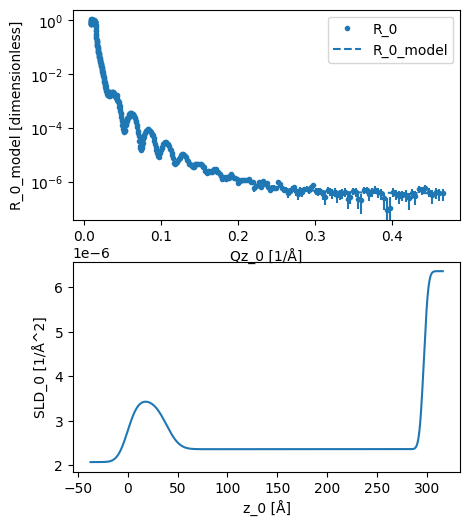

In [22]:
plot(analysed)

Finally, from the string representation of the parameters we can obtain information about the optimised values.

In [23]:
model

Film Model:
  scale: 0.8739516938361336
  background: 3.8894957996927617e-07
  resolution: 0.02 %
  color: black
  sample:
    Film Structure:
    - Si/SiO2 Superphase:
        Si layer/SiO2 layer:
        - Si layer:
            material:
              Si:
                sld: 2.070e-6 1/Å^2
                isld: 0.000e-6 1/Å^2
            thickness: 0.000 Å
            roughness: 0.000 Å
        - SiO2 layer:
            material:
              SiO2:
                sld: 3.470e-6 1/Å^2
                isld: 0.000e-6 1/Å^2
            thickness: 38.727 Å
            roughness: 8.076 Å
    - EasyMultilayer:
        Film Layer:
        - Film Layer:
            material:
              Film:
                sld: 2.360e-6 1/Å^2
                isld: 0.000e-6 1/Å^2
            thickness: 258.510 Å
            roughness: 10.343 Å
    - EasyMultilayer:
        D2O Subphase:
        - D2O Subphase:
            material:
              D2O:
                sld: 6.360e-6 1/Å^2
                is

We note here that the results obtained are very similar to those from the [*refnx* tutorial](https://refnx.readthedocs.io/en/latest/getting_started.html#Fitting-a-neutron-reflectometry-dataset), which is hardly surprising given that we have used the *refnx* engine in this example.